<a href="https://colab.research.google.com/github/treyra/CS155_miniproject3/blob/main/Indecision_Trees_Notebook_MiniProject_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Data Pre-processing



In [ ]:
import numpy as np
from tqdm.notebook import tqdm

In [ ]:
# read in the data
# Import Data
data = np.genfromtxt('https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/shakespeare.txt',delimiter='\t',dtype=None,encoding='ISO-8859-1')
data[-15]

'154'

In [ ]:
# make all words lower case
for i in range(len(data)):
  data[i]=data[i].lower()

In [ ]:
# remove space at beginning of line
for i in range(len(data)):
  while data[i][0] == ' ':
    line = list(data[i])
    data[i] = "".join(line[1:len(line)])

In [ ]:
# remove \n
for i in range(len(data)):
        data[i] = data[i].replace('\n', '')

In [ ]:
# remove punctuation
to_remove = ['.', ',', ';', ':', '?', '!', '-', "'","(",")"]
for k in range(len(to_remove)):
  for i in range(len(data)):
    data[i] = ''.join([j for j in data[i] if j not in to_remove])

In [ ]:
# remove empty lines
# find indices to remove
remove_idx = []
for i in range(len(data)):
  if data[i] == '\n':
    remove_idx.append(i)
  if data[i] == '':
    remove_idx.append(i)
# remove
data_clean = []
for k in range(len(data)):
  if k not in remove_idx:
    data_clean.append(data[k])
data = data_clean

In [ ]:
# remove sonnets which are too long or too short
# always 14 lines long
# check how long each sonnet is - should be 14!
digit_idxs = []
for i in range(len(data)):
  if data[i].isdigit():
    digit_idxs.append(i)
#print(digit_idxs)
# get difference
length = np.diff(np.array(digit_idxs))
#print(length)
# remove the sonnet with too many or too few lines
remove_nbrs = dict()
for i in range(len(length)):
  if length[i]!=15:
    remove_nbrs.update({data[digit_idxs[i]]:length[i]})
# remove the sonnets with the numbers in remove_numbers
remove_idx = []
for i in range(len(data)):
  if data[i] in remove_nbrs:
    print(data[i])
    for k in range(0,remove_nbrs[data[i]]):
      remove_idx.append(i+k)
# remove
data_clean = []
for k in range(len(data)):
  if k not in remove_idx:
    data_clean.append(data[k])
data = data_clean

99
126


In [ ]:
# remove numbers
for i in range(len(data)):
  data[i] = ''.join([j for j in data[i] if not j.isdigit()])
# remove created empty lines again
# find indices to remove
remove_idx = []
for i in range(len(data)):
  if data[i] == '\n':
    remove_idx.append(i)
  if data[i] == '':
    remove_idx.append(i)
# remove
data_clean = []
for k in range(len(data)):
  if k not in remove_idx:
    data_clean.append(data[k])
data = data_clean

In [ ]:
# this is the data per line
data_by_line = data

In [ ]:
# get data per sonnet
# split up in sonnets
nr_sonnets = len(data)/14
data_by_sonnet = [None] * int(nr_sonnets)
i = 0
for k in range(0, len(data), 14):
  cString = ''
  for idx in range(14):
    #print(idx)
    if idx != 0:
      try:
        cString = cString + ' ' + data[k + idx]
      except:
        import pdb; pdb.set_trace()
    else: 
      cString = data[k]
  data_by_sonnet[i] = cString
  i+=1

In [ ]:
# mount drive
# save data by line and data by sonnet
from google.colab import drive
drive.mount('./drive',force_remount=True)

Mounted at ./drive


In [ ]:
# make new file for data per line
with open('/content/drive/My Drive/CS155_miniproject_3/data_line.txt', 'w') as f:
  for item in data_by_line:
        f.write("%s\n" % item)

In [ ]:
# make new file for data per sonnet
with open('/content/drive/My Drive/CS155_miniproject_3/data_sonnet.txt', 'w') as f:
  for item in data_by_sonnet:
        f.write("%s\n" % item)

We can also load the pre-processed data directly as:

In [ ]:
# load the data - for now from drive until we have repo
# open existing text file
data_sonnet_raw = np.genfromtxt('https://raw.githubusercontent.com/treyra/CS155_miniproject3/main/data/data_sonnet.txt',delimiter='\t',dtype=None,encoding='ISO-8859-1')
data_line = np.genfromtxt('https://raw.githubusercontent.com/treyra/CS155_miniproject3/main/data/data_line.txt',delimiter='\t',dtype=None,encoding='ISO-8859-1')

#HMM Model

Based off of HW 6's solution code

In [ ]:
class HiddenMarkovModel:
    '''
    Class implementation of Hidden Markov Models.
    '''

    def __init__(self, A, O):
        '''
        Initializes an HMM. Assumes the following:
            - States and observations are integers starting from 0. 
            - There is a start state (see notes on A_start below). There
              is no integer associated with the start state, only
              probabilities in the vector A_start.
            - There is no end state. 
        Arguments:
            A:          Transition matrix with dimensions L x L.
                        The (i, j)^th element is the probability of
                        transitioning from state i to state j. Note that
                        this does not include the starting probabilities.
            O:          Observation matrix with dimensions L x D.
                        The (i, j)^th element is the probability of
                        emitting observation j given state i.
        Parameters:
            L:          Number of states.
            D:          Number of observations.
            
            A:          The transition matrix.
            
            O:          The observation matrix.
            
            A_start:    Starting transition probabilities. The i^th element
                        is the probability of transitioning from the start
                        state to state i. For simplicity, we assume that
                        this distribution is uniform.
        '''

        self.L = len(A)
        self.D = len(O[0])
        self.A = np.array(A)
        self.O = np.array(O)
        self.A_start = [1. / self.L for _ in range(self.L)]


    def viterbi(self, x):
        '''
        Uses the Viterbi algorithm to find the max probability state 
        sequence corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            max_seq:    Output sequence corresponding to x with the highest
                        probability.
        '''

        M = len(x)      # Length of sequence.

        # The (i, j)^th elements of probs and seqs are the max probability
        # of the prefix of length i ending in state j and the prefix
        # that gives this probability, respectively.
        #
        # For instance, probs[1][0] is the probability of the prefix of
        # length 1 ending in state 0.
        probs = [[0. for _ in range(self.L)] for _ in range(M + 1)]
        seqs = [['' for _ in range(self.L)] for _ in range(M + 1)]

        # Calculate initial prefixes and probabilities.
        for curr in range(self.L):
            probs[1][curr] = self.A_start[curr] * self.O[curr][x[0]]
            seqs[1][curr] = str(curr)

        # Calculate best prefixes and probabilities throughout sequence.
        for t in range(2, M + 1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                max_prob = float("-inf")
                max_prefix = ''

                # Iterate over all possible previous states to find one
                # that would maximize the probability of the current state.
                for prev in range(self.L):
                    curr_prob = probs[t - 1][prev] \
                                * self.A[prev][curr] \
                                * self.O[curr][x[t - 1]]

                    # Continually update max probability and prefix.
                    if curr_prob >= max_prob:
                        max_prob = curr_prob
                        max_prefix = seqs[t - 1][prev]

                # Store the max probability and prefix.
                probs[t][curr] = max_prob
                seqs[t][curr] = max_prefix + str(curr)

        # Find the index of the max probability of a sequence ending in x^M
        # and the corresponding output sequence.
        max_i = max(enumerate(probs[-1]), key=lambda x: x[1])[0]
        max_seq = seqs[-1][max_i]

        return max_seq


    def forward(self, x, normalize=False):
        '''
        Uses the forward algorithm to calculate the alpha probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            alphas:     Vector of alphas.
                        The (i, j)^th element of alphas is alpha_j(i),
                        i.e. the probability of observing prefix x^1:i
                        and state y^i = j.
                        e.g. alphas[1][0] corresponds to the probability
                        of observing x^1:1, i.e. the first observation,
                        given that y^1 = 0, i.e. the first state is 0.
        '''

        M = len(x)      # Length of sequence.
        alphas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Note that alpha_j(0) is already correct for all j's.
        # Calculate alpha_j(1) for all j's.
        for curr in range(self.L):
            alphas[1][curr] = self.A_start[curr] * self.O[curr][x[0]]

        # Calculate alphas throughout sequence.
        for t in range(1, M):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible previous states to accumulate
                # the probabilities of all paths from the start state to
                # the current state.
                for prev in range(self.L):
                    prob += alphas[t][prev] \
                            * self.A[prev][curr] \
                            * self.O[curr][x[t]]

                # Store the accumulated probability.
                alphas[t + 1][curr] = prob

            if normalize:
                norm = sum(alphas[t + 1])
                for curr in range(self.L):
                    alphas[t + 1][curr] /= norm

        return alphas


    def backward(self, x, normalize=False):
        '''
        Uses the backward algorithm to calculate the beta probability
        vectors corresponding to a given input sequence.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
            normalize:  Whether to normalize each set of alpha_j(i) vectors
                        at each i. This is useful to avoid underflow in
                        unsupervised learning.
        Returns:
            betas:      Vector of betas.
                        The (i, j)^th element of betas is beta_j(i), i.e.
                        the probability of observing prefix x^(i+1):M and
                        state y^i = j.
                        e.g. betas[M][0] corresponds to the probability
                        of observing x^M+1:M, i.e. no observations,
                        given that y^M = 0, i.e. the last state is 0.
        '''

        M = len(x)      # Length of sequence.
        betas = [[0. for _ in range(self.L)] for _ in range(M + 1)]

        # Initialize initial betas.
        for curr in range(self.L):
            betas[-1][curr] = 1

        # Calculate betas throughout sequence.
        for t in range(-1, -M - 1, -1):
            # Iterate over all possible current states.
            for curr in range(self.L):
                prob = 0

                # Iterate over all possible next states to accumulate
                # the probabilities of all paths from the end state to
                # the current state.
                for nxt in range(self.L):
                    if t == -M:
                        prob += betas[t][nxt] \
                                * self.A_start[nxt] \
                                * self.O[nxt][x[t]]

                    else:
                        prob += betas[t][nxt] \
                                * self.A[curr][nxt] \
                                * self.O[nxt][x[t]]

                # Store the accumulated probability.
                betas[t - 1][curr] = prob

            if normalize:
                norm = sum(betas[t - 1])
                for curr in range(self.L):
                    betas[t - 1][curr] /= norm

        return betas


    def supervised_learning(self, X, Y):
        '''
        Trains the HMM using the Maximum Likelihood closed form solutions
        for the transition and observation matrices on a labeled
        datset (X, Y). Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to D - 1. In other words, a list of
                        lists.
            Y:          A dataset consisting of state sequences in the form
                        of lists of variable length, consisting of integers 
                        ranging from 0 to L - 1. In other words, a list of
                        lists.
                        Note that the elements in X line up with those in Y.
        '''

        # Calculate each element of A using the M-step formulas.
        for curr in range(self.L):
            for nxt in range(self.L):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M - 1) \
                                if y[i] == curr and y[i + 1] == nxt])
                    den += len([1 for i in range(M - 1) if y[i] == curr])

                self.A[curr][nxt] = num / den

        # Calculate each element of O using the M-step formulas.
        for curr in range(self.L):
            for xt in range(self.D):
                num = 0.
                den = 0.

                for i in range(len(X)):
                    x = X[i]
                    y = Y[i]
                    M = len(x)
        
                    num += len([1 for i in range(M) \
                                if y[i] == curr and x[i] == xt])
                    den += len([1 for i in range(M) if y[i] == curr])

                self.O[curr][xt] = num / den


    def unsupervised_learning(self, X, N_iters):
        '''
        Trains the HMM using the Baum-Welch algorithm on an unlabeled
        datset X. Note that this method does not return anything, but
        instead updates the attributes of the HMM object.
        Arguments:
            X:          A dataset consisting of input sequences in the form
                        of lists of length M, consisting of integers ranging
                        from 0 to D - 1. In other words, a list of lists.
            N_iters:    The number of iterations to train on.
        '''

        # Note that a comment starting with 'E' refers to the fact that
        # the code under the comment is part of the E-step.

        # Similarly, a comment starting with 'M' refers to the fact that
        # the code under the comment is part of the M-step.

        for iteration in tqdm(range(1, N_iters + 1)):
            if iteration % 10 == 0:
                print("Iteration: " + str(iteration))

            # Numerator and denominator for the update terms of A and O.
            A_num = [[0. for i in range(self.L)] for j in range(self.L)]
            O_num = [[0. for i in range(self.D)] for j in range(self.L)]
            A_den = [0. for i in range(self.L)]
            O_den = [0. for i in range(self.L)]

            # For each input sequence:
            for x in X:
                M = len(x)
                # Compute the alpha and beta probability vectors.
                alphas = self.forward(x, normalize=True)
                betas = self.backward(x, normalize=True)

                # E: Update the expected observation probabilities for a
                # given (x, y).
                # The i^th index is P(y^t = i, x).
                for t in range(1, M + 1):
                    P_curr = [0. for _ in range(self.L)]
                    
                    for curr in range(self.L):
                        P_curr[curr] = alphas[t][curr] * betas[t][curr]

                    # Normalize the probabilities.
                    norm = sum(P_curr)
                    for curr in range(len(P_curr)):
                        P_curr[curr] /= norm

                    for curr in range(self.L):
                        if t != M:
                            A_den[curr] += P_curr[curr]
                        O_den[curr] += P_curr[curr]
                        O_num[curr][x[t - 1]] += P_curr[curr]

                # E: Update the expectedP(y^j = a, y^j+1 = b, x) for given (x, y)
                for t in range(1, M):
                    P_curr_nxt = [[0. for _ in range(self.L)] for _ in range(self.L)]

                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] = alphas[t][curr] \
                                                    * self.A[curr][nxt] \
                                                    * self.O[nxt][x[t]] \
                                                    * betas[t + 1][nxt]

                    # Normalize:
                    norm = 0
                    for lst in P_curr_nxt:
                        norm += sum(lst)
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            P_curr_nxt[curr][nxt] /= norm

                    # Update A_num
                    for curr in range(self.L):
                        for nxt in range(self.L):
                            A_num[curr][nxt] += P_curr_nxt[curr][nxt]

            for curr in range(self.L):
                for nxt in range(self.L):
                    self.A[curr][nxt] = A_num[curr][nxt] / A_den[curr]

            for curr in range(self.L):
                for xt in range(self.D):
                    self.O[curr][xt] = O_num[curr][xt] / O_den[curr]

    def generate_emission(self, M):
        '''
        Generates an emission of length M, assuming that the starting state
        is chosen uniformly at random. 
        Arguments:
            M:          Length of the emission to generate.
        Returns:
            emission:   The randomly generated emission as a list.
            states:     The randomly generated states as a list.
        '''

        emission = []
        state = random.choice(range(self.L))
        states = []

        for t in range(M):
            # Append state.
            states.append(state)

            # Sample next observation.
            rand_var = random.uniform(0, 1)
            next_obs = 0

            while rand_var > 0:
                rand_var -= self.O[state][next_obs]
                next_obs += 1

            next_obs -= 1
            emission.append(next_obs)

            # Sample next state.
            rand_var = random.uniform(0, 1)
            next_state = 0

            while rand_var > 0:
                rand_var -= self.A[state][next_state]
                next_state += 1

            next_state -= 1
            state = next_state

        return emission, states


    def probability_alphas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the forward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        # Calculate alpha vectors.
        alphas = self.forward(x)

        # alpha_j(M) gives the probability that the output sequence ends
        # in j. Summing this value over all possible states j gives the
        # total probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum(alphas[-1])
        return prob


    def probability_betas(self, x):
        '''
        Finds the maximum probability of a given input sequence using
        the backward algorithm.
        Arguments:
            x:          Input sequence in the form of a list of length M,
                        consisting of integers ranging from 0 to D - 1.
        Returns:
            prob:       Total probability that x can occur.
        '''

        betas = self.backward(x)

        # beta_j(0) gives the probability of the output sequence. Summing
        # this over all states and then normalizing gives the total
        # probability of x paired with any output sequence, i.e. the
        # probability of x.
        prob = sum([betas[1][k] * self.A_start[k] * self.O[k][x[0]] \
            for k in range(self.L)])

        return prob


def supervised_HMM(X, Y):
    '''
    Helper function to train a supervised HMM. The function determines the
    number of unique states and observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for supervised learning.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        Y:          A dataset consisting of state sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to L - 1. In other words, a list of lists.
                    Note that the elements in X line up with those in Y.
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)

    # Make a set of states.
    states = set()
    for y in Y:
        states |= set(y)
    
    # Compute L and D.
    L = len(states)
    D = len(observations)

    # Randomly initialize and normalize matrices A and O.
    A = [[random.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    O = [[random.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with labeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.supervised_learning(X, Y)

    return HMM


def unsupervised_HMM(X, n_states, N_iters,rng=np.random.RandomState(1)):
    '''
    Helper function to train an unsupervised HMM. The function determines the
    number of unique observations in the given data, initializes
    the transition and observation matrices, creates the HMM, and then runs
    the training function for unsupervised learing.
    Arguments:
        X:          A dataset consisting of input sequences in the form
                    of lists of variable length, consisting of integers 
                    ranging from 0 to D - 1. In other words, a list of lists.
        n_states:   Number of hidden states to use in training.
        
        N_iters:    The number of iterations to train on.
        rng:        The random number generator for reproducible result.
                    Default to RandomState(1).
    '''

    # Make a set of observations.
    observations = set()
    for x in X:
        observations |= set(x)
    
    # Compute L and D.
    L = n_states
    D = len(observations)

    # Randomly initialize and normalize matrices A.
    A = [[rng.random() for i in range(L)] for j in range(L)]

    for i in range(len(A)):
        norm = sum(A[i])
        for j in range(len(A[i])):
            A[i][j] /= norm
    
    # Randomly initialize and normalize matrix O.
    O = [[rng.random() for i in range(D)] for j in range(L)]

    for i in range(len(O)):
        norm = sum(O[i])
        for j in range(len(O[i])):
            O[i][j] /= norm

    # Train an HMM with unlabeled data.
    HMM = HiddenMarkovModel(A, O)
    HMM.unsupervised_learning(X, N_iters)

    return HMM

In [ ]:
########################################
# CS/CNS/EE 155 2018
# Problem Set 6
#
# Author:       Andrew Kang
# Description:  Set 6 HMM helper
########################################

import re
import numpy as np
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from matplotlib import animation
from matplotlib.animation import FuncAnimation


####################
# WORDCLOUD FUNCTIONS
####################

def mask():
    # Parameters.
    r = 128
    d = 2 * r + 1

    # Get points in a circle.
    y, x = np.ogrid[-r:d-r, -r:d-r]
    circle = (x**2 + y**2 <= r**2)

    # Create mask.
    mask = 255 * np.ones((d, d), dtype=np.uint8)
    mask[circle] = 0

    return mask

def text_to_wordcloud(text, max_words=50, title='', show=True):
    plt.close('all')

    # Generate a wordcloud image.
    wordcloud = WordCloud(random_state=0,
                          max_words=max_words,
                          background_color='white',
                          mask=mask()).generate(text)

    # Show the image.
    if show:
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis('off')
        plt.title(title, fontsize=24)
        plt.show()

    return wordcloud

def states_to_wordclouds(hmm, obs_map, max_words=50, show=True):
    # Initialize.
    M = 100000
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = []

    # Generate a large emission.
    emission, states = hmm.generate_emission(M)

    # For each state, get a list of observations that have been emitted
    # from that state.
    obs_count = []
    for i in range(n_states):
        obs_lst = np.array(emission)[np.where(np.array(states) == i)[0]]
        obs_count.append(obs_lst)

    # For each state, convert it into a wordcloud.
    for i in range(n_states):
        obs_lst = obs_count[i]
        sentence = [obs_map_r[j] for j in obs_lst]
        sentence_str = ' '.join(sentence)

        wordclouds.append(text_to_wordcloud(sentence_str, max_words=max_words, title='State %d' % i, show=show))

    return wordclouds


####################
# HMM FUNCTIONS
####################

def parse_observations(text):
    # Convert text to dataset.
    lines = [line.split() for line in text.split('\n') if line.split()]

    obs_counter = 0
    obs = []
    obs_map = {}

    for line in lines:
        obs_elem = []
        
        for word in line:
            word = re.sub(r'[^\w]', '', word).lower()
            if word not in obs_map:
                # Add unique words to the observations map.
                obs_map[word] = obs_counter
                obs_counter += 1
            
            # Add the encoded word.
            obs_elem.append(obs_map[word])
        
        # Add the encoded sequence.
        obs.append(obs_elem)

    return obs, obs_map

def obs_map_reverser(obs_map):
    obs_map_r = {}

    for key in obs_map:
        obs_map_r[obs_map[key]] = key

    return obs_map_r

def sample_sentence(hmm, obs_map, n_words=100):
    # Get reverse map.
    obs_map_r = obs_map_reverser(obs_map)

    # Sample and convert sentence.
    emission, states = hmm.generate_emission(n_words)
    sentence = [obs_map_r[i] for i in emission]

    return ' '.join(sentence).capitalize() + '...'


####################
# HMM VISUALIZATION FUNCTIONS
####################

def visualize_sparsities(hmm, O_max_cols=50, O_vmax=0.1):
    plt.close('all')
    plt.set_cmap('viridis')

    # Visualize sparsity of A.
    plt.imshow(hmm.A, vmax=1.0)
    plt.colorbar()
    plt.title('Sparsity of A matrix')
    plt.show()

    # Visualize parsity of O.
    plt.imshow(np.array(hmm.O)[:, :O_max_cols], vmax=O_vmax, aspect='auto')
    plt.colorbar()
    plt.title('Sparsity of O matrix')
    plt.show()


####################
# HMM ANIMATION FUNCTIONS
####################

def animate_emission(hmm, obs_map, M=8, height=12, width=12, delay=1):
    # Parameters.
    lim = 1200
    text_x_offset = 40
    text_y_offset = 80
    x_offset = 580
    y_offset = 520
    R = 420
    r = 100
    arrow_size = 20
    arrow_p1 = 0.03
    arrow_p2 = 0.02
    arrow_p3 = 0.06
    
    # Initialize.
    n_states = len(hmm.A)
    obs_map_r = obs_map_reverser(obs_map)
    wordclouds = states_to_wordclouds(hmm, obs_map, max_words=20, show=False)

    # Initialize plot.    
    fig, ax = plt.subplots()
    fig.set_figheight(height)
    fig.set_figwidth(width)
    ax.grid('off')
    plt.axis('off')
    ax.set_xlim([0, lim])
    ax.set_ylim([0, lim])

    # Plot each wordcloud.
    for i, wordcloud in enumerate(wordclouds):
        x = x_offset + int(R * np.cos(np.pi * 2 * i / n_states))
        y = y_offset + int(R * np.sin(np.pi * 2 * i / n_states))
        ax.imshow(wordcloud.to_array(), extent=(x - r, x + r, y - r, y + r), aspect='auto', zorder=-1)

    # Initialize text.
    text = ax.text(text_x_offset, lim - text_y_offset, '', fontsize=24)
        
    # Make the arrows.
    zorder_mult = n_states ** 2 * 100
    arrows = []
    for i in range(n_states):
        row = []
        for j in range(n_states):
            # Arrow coordinates.
            x_i = x_offset + R * np.cos(np.pi * 2 * i / n_states)
            y_i = y_offset + R * np.sin(np.pi * 2 * i / n_states)
            x_j = x_offset + R * np.cos(np.pi * 2 * j / n_states)
            y_j = y_offset + R * np.sin(np.pi * 2 * j / n_states)
            
            dx = x_j - x_i
            dy = y_j - y_i
            d = np.sqrt(dx**2 + dy**2)

            if i != j:
                arrow = ax.arrow(x_i + (r/d + arrow_p1) * dx + arrow_p2 * dy,
                                 y_i + (r/d + arrow_p1) * dy + arrow_p2 * dx,
                                 (1 - 2 * r/d - arrow_p3) * dx,
                                 (1 - 2 * r/d - arrow_p3) * dy,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))
            else:
                arrow = ax.arrow(x_i, y_i, 0, 0,
                                 color=(1 - hmm.A[i][j], ) * 3,
                                 head_width=arrow_size, head_length=arrow_size,
                                 zorder=int(hmm.A[i][j] * zorder_mult))

            row.append(arrow)
        arrows.append(row)

    emission, states = hmm.generate_emission(M)

    def animate(i):
        if i >= delay:
            i -= delay

            if i == 0:
                arrows[states[0]][states[0]].set_color('red')
            elif i == 1:
                arrows[states[0]][states[0]].set_color((1 - hmm.A[states[0]][states[0]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')
            else:
                arrows[states[i - 2]][states[i - 1]].set_color((1 - hmm.A[states[i - 2]][states[i - 1]], ) * 3)
                arrows[states[i - 1]][states[i]].set_color('red')

            # Set text.
            text.set_text(' '.join([obs_map_r[e] for e in emission][:i+1]).capitalize())

            return arrows + [text]

    # Animate!
    print('\nAnimating...')
    anim = FuncAnimation(fig, animate, frames=M+delay, interval=1000)

    return anim

Making the syllable dictionary

In [ ]:
!wget https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/Syllable_dictionary.txt

--2021-03-09 21:35:05--  https://raw.githubusercontent.com/lakigigar/Caltech-CS155-2021/main/projects/project3/data/Syllable_dictionary.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33379 (33K) [text/plain]
Saving to: ‘Syllable_dictionary.txt’

Syllable_dictionary 100%[===================>]  32.60K  --.-KB/s    in 0.004s  

2021-03-09 21:35:05 (8.79 MB/s) - ‘Syllable_dictionary.txt’ saved [33379/33379]



In [ ]:
import re
with open('Syllable_dictionary.txt', "r") as f:
  syl_data = f.readlines()
  #dict_exp = dict(re.findall(r'(\S+)\s+(.+)', f.read()))

In [ ]:
# remove all ' or " and \n
# remove punctuation
to_remove = ['-', "'"]
for k in range(len(to_remove)):
  for i in range(len(syl_data)):
    syl_data[i] = ''.join([j for j in syl_data[i] if j not in to_remove])
#print(syl_data[0])
for i in range(len(syl_data)):
  syl_data[i] = syl_data[i].replace('\n', '')
#print(syl_data[0])
# split the lines into words
for i in range(len(syl_data)):
  syl_data[i] = re.findall(r"[\w']+|[.,?;]", syl_data[i])
#print(syl_data[0])
# make syl_data a dictionary
syl_dict = dict()
for line in syl_data:
  #print(line)
  #import pdb; pdb.set_trace()
  syl_dict.update({line[0]: [line[i] for i in range(1, len(line))]})

# Generating Random Sonnets

Extend the HMM class to include the sonnet generation

In [ ]:
class SonnetHiddenMarkovModel ( HiddenMarkovModel ):
    '''
    Class implementation of Hidden Markov Models for rhyming sonnets
    '''

    def __init__(self, A, O,rhyme_array,syl_dict,obs_map):
        
        self.rhyme_array = rhyme_array
        self.syl_dict = syl_dict
        self.obs_map = obs_map
        self.obs_map_r = obs_map_reverser(obs_map)
        HiddenMarkovModel.__init__(self,A,O)


    def generate_sonnet(self):
        # now generate a random sonnet with 14 lines and 10 syllables each
        emission = []
        states = []
        # make sure we have 14 lines
        line_syls = []
        for i in range(0,14):
          # each line with 10 syllables
          emission = []
          states = []
          k = 0
          # Initial state
          states.append(np.random.randint(0,self.L))
          emission.append(np.random.choice(self.D,None, True, self.O[states[0],:]))
          syl_count= syl_dict[self.obs_map_r[emission[0]]]
          if len(syl_count)>1:
            # check to use the one not at the end or just randomly
            not_end_count = [x for x in syl_count if not x.startswith('E')]
            syl_count = not_end_count
            # if syl_count[0][0]!='E':
            #   syl_count = syl_count[0][0]
          try:
            k+=int(syl_count[0])
          except:
            import pdb; pdb.set_trace()
          j=0
          #print(k)
          while k<10:
            #import pdb; pdb.set_trace()
            j+=1
            # generate next word
            states.append(np.random.choice(self.L,None, True, self.A[states[j-1],:]))
            emission.append(np.random.choice(self.D,None, True, self.O[states[j],:]))
            syl_count= syl_dict[self.obs_map_r[emission[j]]]
            #print(self.obs_map_r[emission[j]])
            if len(syl_count)>1:
              end_count = [x for x in syl_count if x.startswith('E')]
              #import pdb; pdb.set_trace()
              if len(end_count) >= 1:
                if k + int(end_count[0][-1]) > 10:
                  # if equal to 10 pick this word and save sentence
                  if k + int(end_count[0][-1]) == 10:
                    syl_count=int(end_count[0][-1])
                # check to use the correct one
                else:
                  for s in syl_count:
                    if s[0]!='E':
                      syl_count = int(s)
              else:
                syl_count = int(syl_count[0])
            else:
              syl_count = int(syl_count[0])
            if k+syl_count>10:
              # regernerate
              while k+syl_count>10:
                states[j] = (np.random.choice(self.L,None, True, self.A[states[j-1],:]))
                emission[j] = (np.random.choice(self.D,None, True, self.O[states[j],:]))
                syl_count= syl_dict[self.obs_map_r[emission[j]]]
                end_count = [x for x in syl_count if x.startswith('E')]
                if len(end_count) >= 1:
                  syl_count=int(end_count[0][-1])
                else:
                  syl_count = int(syl_count[0])
            try:
              k+=syl_count # or just pick the first one
            except:
              import pdb; pdb.set_trace()
            #print(k)
            if k>=10:
              line_syls.append(k)
          sentence = [self.obs_map_r[i] for i in emission]
          print(' '.join(sentence).capitalize())
          # break the line after 4/8/12 lines
          if (i == 3 or i == 7 or i == 11):
            print('\n')
        print(line_syls)

Now input data and train HMM

Modify raw text data into data we can use for our syllable dictionary

In [ ]:
data_sonnet = [[]]
for i,sonnet in enumerate(data_sonnet_raw):
    data_sonnet[i] = sonnet.split()
    if i != len(data_sonnet_raw)-1:
        data_sonnet.append([])

In [ ]:
# create obs map
count = 0
obs = []
obs_map = {}

for line in data_sonnet:
  obs_line = []
  for word in line:
    if word not in obs_map:
      # add new words to the map
      obs_map[word] = count
      count += 1
    # add the encoded words to the line map
    obs_line.append(obs_map[word])
      
    # add the encoded sequence
  obs.append(obs_line)

In [ ]:
# train a HMM (only a few epochs)
hmm5 = unsupervised_HMM(obs, 5, 50)

#Save to drive
np.save('/content/drive/My Drive/CS155_miniproject_3/5_50_A.npy', hmm5.A)    
np.save('/content/drive/My Drive/CS155_miniproject_3/5_50_O.npy', hmm5.O)    

## Load pre-trained HMMs and generate sonnets

To save time, we trained HMMs with 5, 10, 15, and 20 states and saved them to our git hub, we can now load the A and O matricies and generate sonnets directly

Which many of my or when thy no behind
Nor main beauty womens eye within hath
Adonis given beauty on painted scorn
A for with alone figured fulness and


My plot return mine away despite would
Noon which old of me this loves name mock when
New if chose when skill call hath not my eye
Makes the and set of rebuked as thy love


Lives be thou all naked more waste of time
His said thy though advocate hours beauty
Thee deaths former is battring ride me so
To fire pain hot not thou aloft i ear


For son my life be hours or my under
Richproud graces certain from loved a dear
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


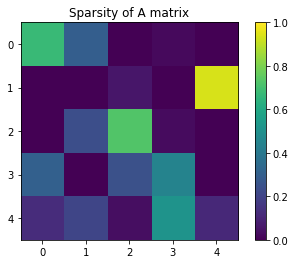

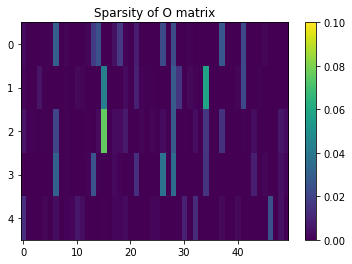

In [ ]:
import requests
import io

response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/5_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/5_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
hmm5 = SonnetHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map)
hmm5.generate_sonnet()

visualize_sparsities(hmm5, O_max_cols=50)

Days by by prognosticate most all in
Her birth rose that you with beauty love and
Not it dates nature to no what break not
Name purest own a have greeing almost


Moods high meadows others rudely worth in
Methinks thou if in thee as for by air
Of should shame sweets soul is watchman and won
My self like making selling widow all


To thy upon spites the lease once arise
Outworn love age nor who be give why i
Things where i thee prove sightless day that have
To doth honour folly spends and i call


The pride argument too near others by
Bestow to love monuments minds worse you
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


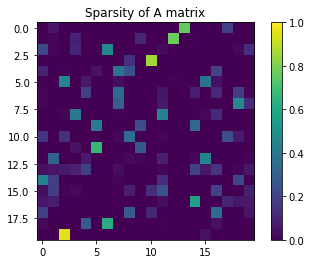

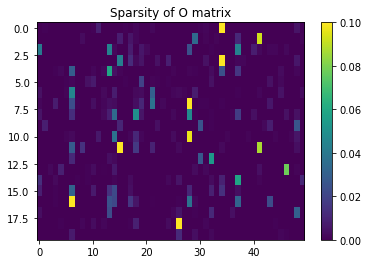

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/20_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/20_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
hmm20 = SonnetHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map)
hmm20.generate_sonnet()

visualize_sparsities(hmm20, O_max_cols=50)

Of ten vile like the tenth may nor wrinkles
I youth spite worse ten although praise and sweet
Make penance dearths without vile a the more
As that count beautys give not thine love is


Do resurvey no man favourites right
I though of womans fault for virtuous of
Poverty canst i when i both dreams his
Or yet suppressed the world me that are thee


Nature with bodys evil and sing or
Sweet which shake all such music of hate to
Gazeth a still services thou enough
Old making they my desperate why leases


Wonder doth wish one truth thou placed i
Mightst and by as nimble eat in of wrongs
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


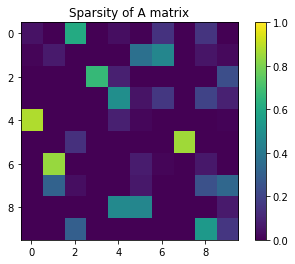

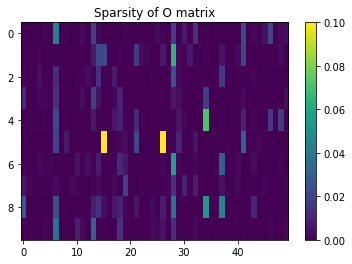

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/10_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/10_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
hmm10 = SonnetHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map)
hmm10.generate_sonnet()

visualize_sparsities(hmm10, O_max_cols=50)

Nay how in this character no on mock
Excuse with relief and from leaves being out
To my sweet folly your glory prouder
The to of my shadows hours quite sue on


Provoke replete approve my reserve this
Draw a time says advantage say every
Catch through surly presence approve of hate
Tell a my to grows my worlds and he till


Which a pursuit wolf in my hath worst this
My tongue tender prey of others the to
Calls we nothing he you quest answers and
Imprint be spring all flatter speed thy faith


Then as your hours excess fear nurseth write
The looking to of on far of hopes and
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


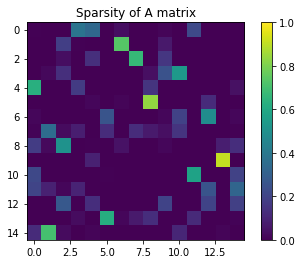

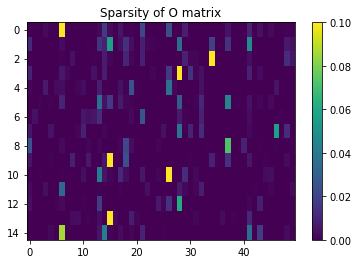

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/15_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/15_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
hmm15 = SonnetHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map)
hmm15.generate_sonnet()

visualize_sparsities(hmm15, O_max_cols=50)

In [ ]:
# now generate a random sonnet with 14 lines and 10 syllables each
emission = []
states = []
L = np.array(hmm8.L)
D = np.array(hmm8.D)  
O = np.array(hmm8.O)
A = np.array(hmm8.A)
obs_map_r = obs_map_reverser(obs_map)

# make sure we have 14 lines
line_syls = []
for i in range(0,14):
  # each line with 10 syllables
  emission = []
  states = []
  k = 0
  # Initial state
  states.append(np.random.randint(0,L))
  emission.append(np.random.choice(D,None, True, O[states[0],:]))
  syl_count= syl_dict[obs_map_r[emission[0]]]
  if len(syl_count)>1:
    # check to use the one not at the end or just randomly
    not_end_count = [x for x in syl_count if not x.startswith('E')]
    syl_count = not_end_count
    # if syl_count[0][0]!='E':
    #   syl_count = syl_count[0][0]
  try:
    k+=int(syl_count[0])
  except:
    import pdb; pdb.set_trace()
  j=0
  #print(k)
  while k<10:
    #import pdb; pdb.set_trace()
    j+=1
    # generate next word
    states.append(np.random.choice(L,None, True, A[states[j-1],:]))
    emission.append(np.random.choice(D,None, True, O[states[j],:]))
    syl_count= syl_dict[obs_map_r[emission[j]]]
    #print(obs_map_r[emission[j]])
    if len(syl_count)>1:
      end_count = [x for x in syl_count if x.startswith('E')]
      #import pdb; pdb.set_trace()
      if len(end_count) >= 1:
        if k + int(end_count[0][-1]) > 10:
          # if equal to 10 pick this word and save sentence
          if k + int(end_count[0][-1]) == 10:
            syl_count=int(end_count[0][-1])
        # check to use the correct one
        else:
          for s in syl_count:
            if s[0]!='E':
              syl_count = int(s)
      else:
        syl_count = int(syl_count[0])
    else:
      syl_count = int(syl_count[0])
    if k+syl_count>10:
      # regernerate
      while k+syl_count>10:
        states[j] = (np.random.choice(L,None, True, A[states[j-1],:]))
        emission[j] = (np.random.choice(D,None, True, O[states[j],:]))
        syl_count= syl_dict[obs_map_r[emission[j]]]
        end_count = [x for x in syl_count if x.startswith('E')]
        if len(end_count) >= 1:
          syl_count=int(end_count[0][-1])
        else:
          syl_count = int(syl_count[0])
    try:
      k+=syl_count # or just pick the first one
    except:
      import pdb; pdb.set_trace()
    #print(k)
    if k>=10:
      line_syls.append(k)
  sentence = [obs_map_r[i] for i in emission]
  print(' '.join(sentence).capitalize())
  # break the line after 4/8/12 lines
  if (i == 3 or i == 7 or i == 11):
    print('\n')
print(line_syls)

Strumpeted disgrace and it might thou foul
Expired prey suffer tired which time but should
Walks issueless their false of of conquest
Of of wards to should to toil outward that


Mine being it blest seem quick threescore and say
Thy angel prove to were out false hath not
Who betraying rotten being the fair and
Deep not triumph of my praise day my some


Who amis some lives my but could by did
Selfexample hath think it affections
Eye did are shore by filching beauty sin
Thee on what brief active made but not then


Virtue commence and richer of thy thou
Winter and but that their till doth for but
[10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10]


# Rhyming HMM

Loading the rhyming dictionary made using the example rhymes in the training data

In [ ]:
# Loading from our github
rhyme_array_raw = np.genfromtxt('https://raw.githubusercontent.com/treyra/CS155_miniproject3/main/data/rhyme_list.txt',delimiter='\t',dtype=None,encoding='ISO-8859-1')

rhyme_array = np.zeros((len(rhyme_array_raw),2),dtype=object)
for i,rhymes in enumerate(rhyme_array_raw):
    #Stored as a np array written to a text file, so remove the brackets
    rhyme_array[i,0] = rhymes.split()[0][2:-1]
    rhyme_array[i,1] = rhymes.split()[1][1:-2]

In [ ]:
class RhymingHiddenMarkovModel ( HiddenMarkovModel ):
    '''
    Class implementation of Hidden Markov Models for rhyming sonnets
    '''

    def __init__(self, A, O,rhyme_array,syl_dict,obs_map):
        
        self.rhyme_array = rhyme_array
        self.syl_dict = syl_dict
        self.obs_map = obs_map
        self.obs_map_r = obs_map_reverser(obs_map)
        HiddenMarkovModel.__init__(self,A,O)

    def emit_line(self, numSyls = 10, endSeed=None):
        """
        Generate a random line backwards to forwards
        using a seeded ending word, if provided
        Parameters
        ----------
        numSyls : int
            Number of syllables the line should have. 
            Default is 10
        endSeed : tuple (int,string)
            The HMM state and the string the line will
            end in, if any.
        """
        #Line to emit
        line = None 

        #No seed, pick random initial state
        if endSeed is None:
            state = np.random.randint(0,self.L)
            line = np.array([np.random.choice(self.D,p=self.O[state,:])])
        else:
            state = endSeed[0]
            line = np.array([self.obs_map[endSeed[1]]])
        k = 0
        # Initial state
        syl_count= syl_dict[self.obs_map_r[line[0]]]
        if len(syl_count)>1:
          # check to use the one not at the end or just randomly
          not_end_count = [x for x in syl_count if not x.startswith('E')]
          syl_count = not_end_count
          # if syl_count[0][0]!='E':
          #   syl_count = syl_count[0][0]
        try:
          k+=int(syl_count[0])
        except:
          import pdb; pdb.set_trace()
        #Now loop backwards and generate rest of line before word
        j = 0
        prevState = state
        while k < 10:
            j+=1
            # generate next word (NOTE: we flipped the A matrix because we want to know the 
            #probability of transitioning TO the previous state)
            state = np.random.choice(self.L,p= self.A[:,prevState]/np.linalg.norm(self.A[:,prevState],1))
            line = np.concatenate(([np.random.choice(self.D,p=self.O[state,:])],line)) 
            syl_count= syl_dict[self.obs_map_r[line[0]]]
            #print(obs_map_r[line[0]])
            if len(syl_count)>1:
              end_count = [x for x in syl_count if x.startswith('E')]
              if len(end_count) >= 1:
                if k + int(end_count[0][-1]) > 10:
                  # if equal to 10 pick this word and save sentence
                  if k + int(end_count[0][-1]) == 10:
                    syl_count=int(end_count[0][-1])
                # check to use the correct one
                else:
                  for s in syl_count:
                    if s[0]!='E':
                      syl_count = int(s)
              else:
                syl_count = int(syl_count[0])
            else:
              syl_count = int(syl_count[0])
            if k+syl_count>10:
              # regernerate
              while k+syl_count>10:
                state = np.random.choice(self.L,p= self.A[:,prevState]/np.linalg.norm(self.A[:,prevState],1))
                line[0] = (np.random.choice(self.D,p = self.O[state,:]))
                syl_count= syl_dict[self.obs_map_r[line[0]]]
                end_count = [x for x in syl_count if x.startswith('E')]
                if len(end_count) >= 1:
                  syl_count=int(end_count[0][-1])
                else:
                  syl_count = int(syl_count[0])
            try:
              k+=syl_count # or just pick the first one
            except:
              import pdb; pdb.set_trace()
            #print(k)
            if k>=10:
              return [self.obs_map_r[i] for i in line]
    def genRhymingSonnet(self):
        """
        Uses rhyme dict to seed lines for a rhyming sonnet
        """
        sonnet = np.array([[]],dtype=object)
        #Generate 14 rhyming lines
        #List of indicies already picked and the word in the pair used
        #(set to -1 initially)
        used = np.zeros((7,2)) - 1

        for i in range(14):
            #Let the first word in the rhyme pair be in any order
            firstWord = -1
            if i == 0 or i == 1 or i == 4 or i == 5 or i == 8 or i == 9 or i == 12:
                rhyme = np.random.randint(0,len(self.rhyme_array))
                #Redraw for uniqueness (desired behavior?)
                while rhyme in used:
                    rhyme = np.random.randint(0,len(self.rhyme_array))
                #Using integer math to get the right index for each pair of rhymes
                used[int((i+1)/2),0] = rhyme
                #Randomly draw the last word, save so we use other next time
                lastWord = np.random.randint(0,len(self.rhyme_array[rhyme]))
                used[int((i+1)/2),1] = lastWord
            else:
                #Using integer math to get the right index for each pair of rhymes
                rhyme = int(used[int((i-1)/2),0])
                #Get the other word in pair (this is to allow for N lenght lists of rhymes)
                lastWord = np.random.randint(0,len(self.rhyme_array[rhyme])-1)
                #If we got the word we already used, just assign the one we excluded from the draw
                if lastWord == used[int((i-1)/2),1]:
                    lastWord = len(self.rhyme_array[rhyme])-1
                lastWord = int(lastWord)
            line = self.emit_line(endSeed=(np.random.randint(0,self.L),self.rhyme_array[rhyme,lastWord]))
            print(i,end = ": ")
            print(' '.join(line).capitalize())
            sonnet = np.append(sonnet,line)           
        return sonnet


In [ ]:
# train a HMM (only a few epochs)
betterHMM = unsupervised_HMM(obs, 20, 50)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50



In [ ]:
# mount drive
# save data by line and data by sonnet
from google.colab import drive
drive.mount('./drive',force_remount=True)

Mounted at ./drive


In [ ]:
np.save('/content/drive/My Drive/CS155_miniproject_3/20_50_A.npy', betterHMM.A)    
np.save('/content/drive/My Drive/CS155_miniproject_3/20_50_O.npy', betterHMM.O)    

In [ ]:
#Gen the rhyming Sonnet
rhyme_hmm = RhymingHiddenMarkovModel(hmm8.A, hmm8.O,rhyme_array,syl_dict,obs_map)
sonnet = rhyme_hmm.genRhymingSonnet()

0: Desire of the shadow in cheeks a are
1: Five one lack she thy yore moods self love stand
2: Which and my up hand of yet let sun care
3: Thee marriage if lies this grows this said land
4: Than my to mortal hath friends since to need
5: That on and none my her making your hope
6: Limbs knew name store active anchored exceed
7: Times twofold back prime cures the at the scope
8: Keeps taught lovst like my another thy white
9: She may favour hate day and name alone
10: Thee darling though o depends a delight
11: Change or epitaph see eves leave truth prone
12: Thing is wit second methinks receivest
13: Pleasing is be not thou i deceivest


In [ ]:
#Gen the rhyming Sonnet
rhyme_hmm = RhymingHiddenMarkovModel(betterHMM.A, betterHMM.O,rhyme_array,syl_dict,obs_map)
sonnet = rhyme_hmm.genRhymingSonnet()

0: Policy whilst every being poor feeding
1: Or i daily is i my wantonly
2: Self by persuade your hours which right needing
3: Woe hems shame mayst find can beauty love dye
4: Even watching waste heart time pity for pride
5: And and in till boast i in proceeds ill
6: One bids answers why kingdom she break ride
7: In in thou be thou filching in in skill
8: Hours time might if may any might left wronk
9: By in thou in suit thou mercy and moan
10: And were out what man i my my nights tongue
11: Last this his still think the love this the gone
12: Live worth she woe and griefs your tell disgrace
13: For thou grace a five your thy beautys face


In [ ]:
# train a HMM (only a few epochs)
betterHMM = unsupervised_HMM(obs, 15, 50)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50



In [ ]:
np.save('/content/drive/My Drive/CS155_miniproject_3/15_50_A.npy', betterHMM.A)    
np.save('/content/drive/My Drive/CS155_miniproject_3/15_50_O.npy', betterHMM.O)    

In [ ]:
# train a HMM (only a few epochs)
betterHMM = unsupervised_HMM(obs, 10, 50)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50



In [ ]:
np.save('/content/drive/My Drive/CS155_miniproject_3/10_50_A.npy', betterHMM.A)    
np.save('/content/drive/My Drive/CS155_miniproject_3/10_50_O.npy', betterHMM.O)    

In [ ]:
# train a HMM (only a few epochs)
hmm5 = unsupervised_HMM(obs, 5, 50)

Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50



In [ ]:
np.save('/content/drive/My Drive/CS155_miniproject_3/5_50_A.npy', hmm5.A)    
np.save('/content/drive/My Drive/CS155_miniproject_3/5_50_O.npy', hmm5.O)    

In [ ]:
#Gen the rhyming Sonnet
rhyme_hmm = RhymingHiddenMarkovModel(betterHMM.A, betterHMM.O,rhyme_array,syl_dict,obs_map)
sonnet = rhyme_hmm.genRhymingSonnet()

0: Tongue beauties lays out proud my lips taken
1: Leads thou how true birds cease back assured
2: Inward the a for pale sweet keep shaken
3: Now that all thine hath hath if and endured
4: Tan thee i that why fire is that for stage
5: I must form i despite those do then verse
6: Dulness forgive friend fortune absence rage
7: Is many the from i desire birds rehearse
8: True thy suns but i victor doth behind
9: Mistress in they then even of believe style
10: Worlds finds sweet gravity these how since kind
11: My consumst my rigour form kind compile
12: Height the is a a seeming house my know
13: Needs then so state edge which i gain eyes show


In [ ]:
#Gen the rhyming Sonnet
rhyme_hmm = RhymingHiddenMarkovModel(hmm5.A, hmm5.O,rhyme_array,syl_dict,obs_map)
sonnet = rhyme_hmm.genRhymingSonnet()

0: Whom from invention some poor with a thee
1: Who say where and and which not largess love
2: Which be for i red and i pleasure me
3: Rare touches from wet is on my in prove
4: That confounds happy as looks for i thine
5: Through mind love fears fortune speak ordering
6: Should and alone have but enough to mine
7: My his on at preposterously in sing
8: And and folly hate untutored it edge
9: Poor sum long high remembered high as dyed
10: Red you being would as although privilege
11: To a is wombs his all to dignified
12: Who his the sins loves thy my not swearing
13: Swear haste but beauty rich ever bearing


0: Prime one deeds day injury thou when mind
1: Else am other pen am can was day prove
2: Heart be as eyes fire favourites behind
3: To with the her make of worlds stand would love
4: Shall pursuing glass may deeds enmity
5: Taste tell what can perhaps our eyes with power
6: But not ear death they blamed posterity
7: Of own sight beautys and did that truth flower
8: Knife shadows prize walls past ye crawls though pain
9: Self holds not acquaintance the till say light
10: Perjured rarities he nor thou the slain
11: Images unless rank that where in bright
12: Of all to good fond of youth the which bough
13: Time to unbless is death thee record now


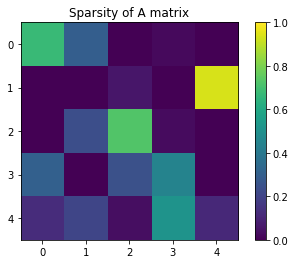

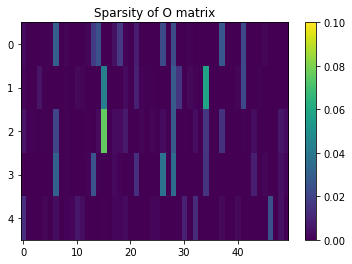

In [ ]:
import requests
import io

response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/5_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/5_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
rhyme_hmm = RhymingHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map)
sonnet = rhyme_hmm.genRhymingSonnet()

visualize_sparsities(rhyme_hmm, O_max_cols=50)

0: Dead right shadows lips so brass heavy crowned
1: If like then which tell since prognosticate
2: At if to love nor while weeds new confound
3: If saw worse well drown let leaves belongs date
4: The with me doom his his think loathsome sad
5: Late two but darkness me still would of sea
6: Thine much i thy my it thus thy that glad
7: Seen expressed hast that sorrow why me plea
8: Wanton they sovereign this thou heart large give
9: The beautys the hence forests be pleasure
10: Poor great religious that vassal thy live
11: Not and still do constant sick say measure
12: Thee others me learning defect the wide
13: On salve of am from not upon belied


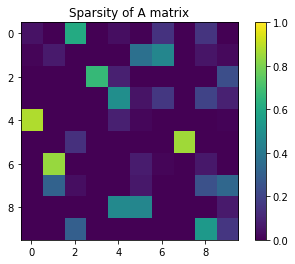

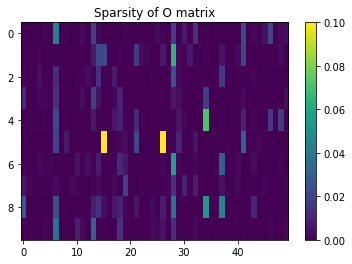

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/10_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/10_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
rhyme_hmm10 = RhymingHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map)
sonnet = rhyme_hmm10.genRhymingSonnet()

visualize_sparsities(rhyme_hmm10, O_max_cols=50)

In [ ]:
np.max(rhyme_hmm10.O[5,:]),np.argsort(rhyme_hmm10.O[5,:])[::-1][0:10],rhyme_hmm10.obs_map_r[np.argsort(rhyme_hmm10.O[5,:])[-1]],rhyme_hmm10.obs_map_r[np.argsort(rhyme_hmm10.O[5,:])[-2]],rhyme_hmm10.obs_map_r[np.argsort(rhyme_hmm10.O[5,:])[-3]],rhyme_hmm10.obs_map_r[np.argsort(rhyme_hmm10.O[5,:])[-4]],rhyme_hmm10.obs_map_r[80],np.sort(rhyme_hmm10.O[5,:])[::-1][0:10]

(0.2023393038376952,
 array([ 15,  26,  41, 494,  80,  76,  21,   6,  74, 575]),
 'the',
 'thou',
 'a',
 'me',
 'thee',
 array([0.2023393 , 0.10087567, 0.03074391, 0.02997068, 0.02792159,
        0.02745061, 0.02157366, 0.02013893, 0.01847856, 0.01570788]))

0: I see change to and be in pattern worth
1: Happy of both is shall let i devil
2: Feel lusty of thy thee to near to forth
3: Thy your thee came lends crime such or evil
4: Thy beguiled end thy my taker mens hand
5: My my thy unthrifts gentlest my thy fade
6: Is with a must i rondure like my stand
7: Composed is show from admiring shade
8: Whose time thy faster rhyme hours my my change
9: Before so by your the in suffer truth
10: True fame under ever thou from in strange
11: Mute strengthened then alone you who thou youth
12: My poor thy more thy me repay misplaced
13: Directed razed wilt if true rare disgraced


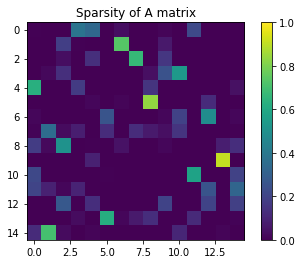

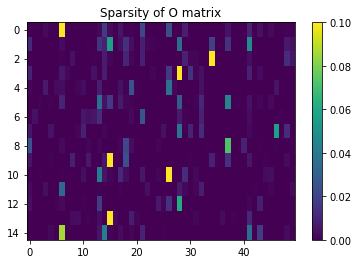

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/15_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/15_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
rhyme_hmm15 = RhymingHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map)
sonnet = rhyme_hmm15.genRhymingSonnet()

visualize_sparsities(rhyme_hmm15, O_max_cols=50)

In [ ]:
rhyme_hmm15.obs_map["his"]

21

0: Nor of gone he those with for die and lie
1: Indeed that what grown mourning blunt aright
2: New the his torment the a thought defy
3: Thine accents might old beauty growth some sight
4: Pipe but jollity not face derive me
5: For still to sometime with advantage right
6: For am break my my my fill tend my thee
7: Prime base youth to ground to or so in sight
8: Love thievish i all borne guard can good cold
9: Strong so but with most and of ten lived make
10: Thy thy fall some happy here jaws behold
11: To friend it self of so is and not sake
12: So can great that time state so with what thee
13: Some on too sympathized words nor i me


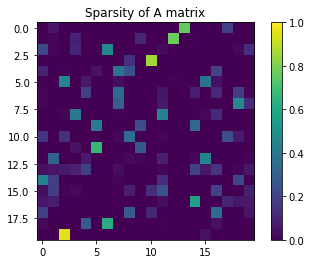

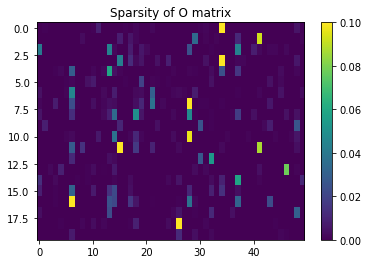

In [ ]:
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/20_50_A.npy?raw=true')
response.raise_for_status()
loadA = np.load(io.BytesIO(response.content))  
response = requests.get('https://github.com/treyra/CS155_miniproject3/blob/main/trained_hmms/20_50_O.npy?raw=true')
response.raise_for_status()
loadO = np.load(io.BytesIO(response.content)) 
rhyme_hmm20 = RhymingHiddenMarkovModel(loadA, loadO,rhyme_array,syl_dict,obs_map)
sonnet = rhyme_hmm20.genRhymingSonnet()

visualize_sparsities(rhyme_hmm20, O_max_cols=50)

In [ ]:
rhyme_hmm20.obs_map["my"],rhyme_hmm20.O[0,132],rhyme_hmm20.O[13,132],rhyme_hmm20.A[0,13],rhyme_hmm20.A[13,0],rhyme_hmm20.O[:,132]

(132,
 0.3195765348461181,
 1.2602427398316739e-20,
 0.7585731360225366,
 0.040673774237136605,
 array([3.19576535e-01, 4.30606142e-03, 2.05225203e-36, 8.38775645e-40,
        1.24344058e-10, 3.44218527e-57, 1.21413709e-33, 4.05696066e-24,
        1.18864722e-36, 1.74800652e-25, 1.61602623e-20, 1.06162193e-02,
        7.18120667e-35, 1.26024274e-20, 1.01331619e-03, 1.35177047e-36,
        1.72316312e-10, 3.81601139e-10, 4.71151323e-15, 1.93685490e-38]))

#RNN model